In [1]:
import pickle
import os

import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from dataset.dataset import load_data
from dataset.utils import *
import matplotlib.pyplot as plt

from models.vgg import *
from models.converter import convert
import lrp
import torchexplain

torch.set_printoptions(sci_mode=False)

/home/jack/anaconda3/envs/explainable-concept-bottleneck/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Joint Model
def ModelXtoCtoY(n_class_attr, pretrained, freeze, num_classes, n_attributes, expand_dim, use_relu, use_sigmoid, train=True, **kwargs):
	vgg_model = vgg16_bn(pretrained=pretrained, num_classes=num_classes, n_attributes=n_attributes, bottleneck=True, expand_dim=expand_dim, train=train, **kwargs)
	model1 = x_to_c_model(freeze=freeze, model=vgg_model)
	if n_class_attr == 3:
		model2 = MLP(input_dim=n_attributes * n_class_attr, num_classes=num_classes, expand_dim=expand_dim, train=train)
	else:
		model2 = MLP(input_dim=n_attributes, num_classes=num_classes, expand_dim=expand_dim, train=train)
	return End2EndModel(model1, model2, use_relu, use_sigmoid, n_class_attr)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Device:", device, torch.cuda.get_device_name(0))
else:
    print("Device:", device)

Device: cpu


/home/jack/anaconda3/envs/explainable-concept-bottleneck/lib/python3.8/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
def register_hooks(layer, in_, grad_, name):
	def get_in(self, l_in, l_out):
		in_[name] = l_in[0]

	def get_grad(self, grad_in, grad_out):
		grad_[name] = grad_in[0]
	fwd = layer.register_forward_hook(get_in)
	bkd = layer.register_full_backward_hook(get_grad)
	return fwd, bkd


def remove_hooks(hooks):
	for i in hooks:
		i.remove()

In [5]:
##### https://github.com/fhvilshoj/TorchLRP/blob/74253a1be05f0be0b7c535736023408670443b6e/examples/visualization.py#L60
def heatmap(X, cmap_name="seismic"):
    cmap = plt.cm.get_cmap(cmap_name)
    
    if len(X.shape) == 2:  # Input tensor is a 1xn vector, add 
        X = X.unsqueeze(1)

    if X.shape[1] in [1, 3]:  # move channel index to end + convert to np array
        if len(X.shape) == 3:
            X = X.permute(0, 2, 1).detach().cpu().numpy()
        else:
            X = X.permute(0, 2, 3, 1).detach().cpu().numpy()
    if isinstance(X, torch.Tensor):  # convert tensor to np array
        X = X.detach().cpu().numpy()

    shape = X.shape
    tmp = X.sum(axis=-1) # Reduce channel axis

    tmp = project(tmp, output_range=(0, 255)).astype(int)
    tmp = cmap(tmp.flatten())[:, :3].T
    tmp = tmp.T

    shape = list(shape)
    shape[-1] = 3
    return tmp.reshape(shape).astype(np.float32)

def project(X, output_range=(0, 1)):
    absmax = np.abs(X).max(axis=tuple(range(1, len(X.shape))), keepdims=True)
    X /= absmax + (absmax == 0).astype(float)
    X = (X+1) / 2. # range [0, 1]
    X = output_range[0] + X * (output_range[1] - output_range[0]) # range [x, y]
    return X

In [6]:
IMG_SIZE =  299
training_transform = transforms.Compose([
    transforms.ColorJitter(brightness=32/255, saturation=(0.5, 1.5)),
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), #implicitly divides by 255
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [2, 2, 2])
    #transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ], std = [ 0.229, 0.224, 0.225 ]),
    ])

other_transform = transforms.Compose([
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(), #implicitly divides by 255
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [2, 2, 2])
    #transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ], std = [ 0.229, 0.224, 0.225 ]),
    ])

In [7]:
use_relu = False
use_sigmoid = False
freeze = False
expand_dim = 0
pretrained = False
train = True
n_class_attr = 2

In [8]:
# CBM dataset split and model (112 class level concpts)

N_CONCEPT = 112

val_split = pickle.load(open("./dataset/CUB/dataset_splits/CBM_dataset_split/test.pkl", "rb"))
train_split = pickle.load(open("./dataset/CUB/dataset_splits/CBM_dataset_split/train.pkl", "rb"))
val_loader = load_data("./dataset/CUB/dataset_splits/CBM_dataset_split/val.pkl", 16, image_dir='dataset/CUB/data/images', return_orig=True)
train_loader = load_data("./dataset/CUB/dataset_splits/CBM_dataset_split/train.pkl", 16, image_dir='dataset/CUB/data/images')

class_index_to_string = IndexToString("./dataset/CUB/data/classes.txt", classes=True)
concept_index_to_string = IndexToString("./dataset/CUB/dataset_splits/CBM_dataset_split/attributes.txt")

XtoCtoY_model = ModelXtoCtoY(n_class_attr=n_class_attr, pretrained=pretrained, num_classes=200, n_attributes=112, expand_dim=expand_dim, freeze=freeze, use_relu=use_relu, use_sigmoid=use_sigmoid, train=train)
XtoCtoY_model.load_state_dict(torch.load("./saves/CBM_paper/state_dict/sequential_seed1.pth"))
XtoCtoY_model.to(device)
XtoCtoY_model.eval()

print("model loaded")

model loaded


In [16]:
# explanable CBM dataset split and model (312 sample level concpts)

N_CONCEPT = 312

val_split = pickle.load(open("./dataset/CUB/explainable_CUB_dataset_split_train_val/val.pkl", "rb"))
train_split = pickle.load(open("./dataset/CUB/explainable_CUB_dataset_split_train_val/train.pkl", "rb"))
val_loader = load_data("./dataset/CUB/explainable_CUB_dataset_split_train_val/val.pkl", 16, image_dir='dataset/CUB/data/images', return_orig=True)
train_loader = load_data("./dataset/CUB/explainable_CUB_dataset_split_train_val/train.pkl", 16, image_dir='dataset/CUB/data/images')

class_index_to_string = IndexToString("./dataset/CUB/data/classes.txt", classes=True)
concept_index_to_string = IndexToString("./dataset/CUB/data/attributes.txt")

XtoCtoY_model = ModelXtoCtoY(n_class_attr=n_class_attr, pretrained=False, num_classes=200, n_attributes=312, expand_dim=0, freeze=False, use_relu=False, use_sigmoid=False, train=True)
XtoCtoY_model.load_state_dict(torch.load("./saves/explainable/state_dict/joint_explainable_dataset.pth"))
XtoCtoY_model.to(device)
XtoCtoY_model.eval()

print("model loaded")

FileNotFoundError: [Errno 2] No such file or directory: './dataset/CUB/explainable_CUB_dataset_split_train_val/val.pkl'

In [9]:
print(XtoCtoY_model.first_model)

#CtoY_model = convert(XtoCtoY_model.sec_model).to(device)
                                                 
CtoY_model = MLP(N_CONCEPT, 200, expand_dim=expand_dim, train=False).to(device)
CtoY_model.load_state_dict(XtoCtoY_model.sec_model.state_dict())

print(CtoY_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

True image size (channels, width, height): torch.Size([3, 299, 299])
True  image label: Scott_Oriole
True  image concepts: tensor([0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 1.])


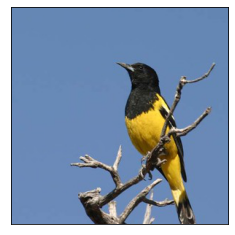

Predicted image label: Scott_Oriole
Predicted concepts: tensor([[    0.0000,     0.0000,     1.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     1.0000,     1.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     1.0000,     1.0000,     0.0000,     0.0000,     0.0000,
             1.0000,     0.0000,     0.0000,     0.0000,     0.9999,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000,     1.0000,     0.0000,
             0.0000,     1.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     1.0000,
             0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     1.0000,
             0.0000,     0.0000,     1.0000,     1.0000,     0.9998,     0.0000,
             0.0000,     0.0000,     0.0000,     1.0000,     0.0000,     0.0000,
             0.0000,     1.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     1.0000,     0.0000,     0.00

In [27]:
imageId = 10

images, labels, concepts, original_imgs = next(iter(val_loader))
image, label = images[imageId].to(device), labels[imageId].to(device)

# print / show input
print("True image size (channels, width, height):", image.size())
print("True  image label:", class_index_to_string(label.item()))
print("True  image concepts:", concepts[imageId])

plt.xticks([])
plt.yticks([])
plt.imshow(original_imgs[imageId].squeeze().permute(1, 2, 0))
plt.show()


image = image.unsqueeze(0)
image.requires_grad_(True)
image.grad = None

# get model prediction and LRP map for classification
prediction = XtoCtoY_model(image)
_, pred = torch.max(prediction[0], 1)

print("Predicted image label:", class_index_to_string(pred.item()))
pred_concepts_readable = torch.nn.Sigmoid()(prediction[1])
print("Predicted concepts:", pred_concepts_readable)

# print concept as string if prediction is >= 0.5
for idx, i in enumerate(pred_concepts_readable[0]):
    if i.item() >= 0.5:
        print(idx + 1, concept_index_to_string(idx), i.item())

In [28]:
image, label = images[imageId].to(device), labels[imageId].to(device)
#image, label = images.to(device), labels.to(device)
image = image.unsqueeze(0)
image.requires_grad_(True)
image.grad = None  # Reset gradient

#CtoY_model_lrp = convert(CtoY_model).to(device)

pred_concepts = XtoCtoY_model.first_model(image)
CtoY_out = CtoY_model(pred_concepts)
#CtoY_out = CtoY_model_lrp.forward(image, explain=True)
_, pred = torch.max(CtoY_out, 1)

filter_out = torch.zeros_like(CtoY_out)
filter_out[:,pred.item()] += 1

# Get the gradient of each input
image_gradient = torch.autograd.grad(
    CtoY_out,
    pred_concepts,
    grad_outputs=filter_out,
    retain_graph=False)[0]

112


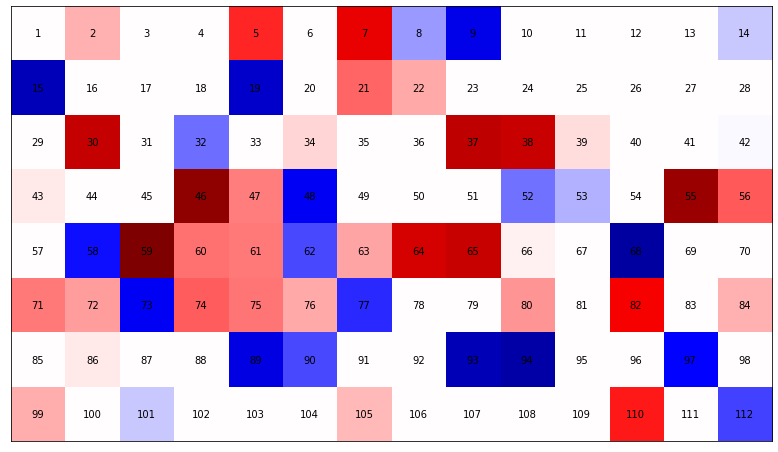

59 has_forehead_color::white 0.32669031620025635
46 has_throat_color::grey 0.3058813512325287
55 has_forehead_color::brown 0.28890424966812134
37 has_upper_tail_color::buff 0.24483337998390198
30 has_back_color::white 0.23543013632297516
65 has_nape_color::brown 0.23467347025871277
38 has_head_pattern::eyebrow 0.2299177050590515
64 has_under_tail_color::buff 0.21686038374900818
7 has_wing_color::yellow 0.18905049562454224
82 has_shape::duck-like 0.17188185453414917
110 has_wing_pattern::spotted 0.14595839381217957
5 has_wing_color::brown 0.13861094415187836
56 has_forehead_color::grey 0.10633927583694458
74 has_belly_color::black 0.10435489565134048
21 has_underparts_color::white 0.098465695977211
60 has_under_tail_color::brown 0.09111753106117249
75 has_belly_color::white 0.08882125467061996
71 has_belly_color::brown 0.08575373888015747
61 has_under_tail_color::grey 0.08549653738737106
47 has_throat_color::yellow 0.0817779079079628
80 has_size::medium_(9_-_16_in) 0.06669250875711441
7

In [29]:
#print(image_gradient.size())
#attr = heatmap(image_gradient, cmap_name='seismic')
#print(attr)

#plt.xticks([])
#plt.yticks([])
#plt.title(label=class_index_to_string(pred.item()), fontsize=15)
#plt.imshow(attr.reshape(8, 14), cmap='seismic')
#plt.savefig(f'temp/{pred.item()}.png')
#plt.show()

#plt.close()
print(N_CONCEPT)
if N_CONCEPT == 112:
    grad_plot = image_gradient.reshape(8, 14)
    #grad_plot = image_gradient
    plt.figure(figsize=(14,8))
    #plt.figure(figsize=(112, 1))
else:
    #grad_plot = image_gradient.reshape(13, 24)
    grad_plot = image_gradient
    #plt.figure(figsize=(24,13))
    plt.figure(figsize=(312, 1))


current_index = 0
for y in range(grad_plot.size(0)):
    for x in range(grad_plot.size(1)):
        plt.text(x, y, f'{current_index + 1}',
                 horizontalalignment='center',
                 verticalalignment='center',
                 )
        current_index += 1

        
sorted, indexes = image_gradient[0].sort(descending=True)


# center 0 for min and max values on figure
if abs(sorted[0].item()) > abs(sorted[-1].item()):
    vmin = 0 - abs(sorted[0].item())
    vmax = abs(sorted[0].item())
else:
    vmin = 0 - abs(sorted[-1].item())
    vmax = abs(sorted[-1].item())

if N_CONCEPT == 112:
    #plt.imshow(image_gradient.cpu().reshape(8, 14), cmap='seismic', vmin=vmin, vmax=vmax)
    plt.imshow(image_gradient.cpu().reshape(8, 14), cmap='seismic', vmin=vmin, vmax=vmax)
else:
    #plt.imshow(image_gradient.cpu().reshape(13, 24), cmap='seismic')
    plt.imshow(image_gradient.cpu(), cmap='seismic')
    
plt.xticks([])
plt.yticks([])
plt.grid()
plt.show()

plt.close()

# print concept as string in order of gradient from highest to lowest
for relevance, idx in zip(sorted, indexes):
    print(idx.item() + 1, concept_index_to_string(idx.item()), relevance.item())

In [12]:
# Register hooks
inputs, gradients = {}, {}
hooks = register_hooks(CtoY_model, inputs, gradients, 'grads')  # This is the highest layer where all grads match

pred_concepts = XtoCtoY_model.first_model(image)
CtoY_out = CtoY_model(pred_concepts)
_, pred = torch.max(CtoY_out, 1)

filter_out = torch.zeros_like(CtoY_out)
filter_out[:,pred.item()] += 1

# Get the gradient of each input
image_gradient = torch.autograd.grad(
    CtoY_out,
    pred_concepts,
    grad_outputs=filter_out,
    retain_graph=True)[0]

ins = inputs['grads'][0]
grads = gradients['grads'][0]



# Calculate the proportions per input concept

ratios = []
for in_, grad_ in zip(ins, grads):
    ratios.append(grad_ / in_)
    
#print(ratios)

balaced_ratios = []
for idx, i in enumerate(ratios):
    balaced_ratios.append((idx, i / sum(ratios)))

print("Total ratios:", sum([i[1] for i in balaced_ratios]))

balaced_ratios.sort(key=lambda x: x[1].item(), reverse=True)

for ratio in balaced_ratios:
    print(f"{ratio[0]+1}: {concept_index_to_string(ratio[0])} ({round(float(ratio[1]*100), 2)}%)")

Total ratios: tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)
15: has_upperparts_color::white (6.04%)
93: has_primary_color::yellow (5.83%)
89: has_tail_pattern::multi-colored (5.39%)
9: has_wing_color::white (5.23%)
19: has_underparts_color::yellow (5.2%)
68: has_nape_color::black (4.93%)
73: has_belly_color::yellow (4.84%)
32: has_tail_shape::notched_tail (4.47%)
94: has_primary_color::black (4.42%)
97: has_leg_color::grey (4.37%)
112: has_wing_pattern::multi-colored (4.36%)
52: has_bill_length::about_the_same_as_head (4.3%)
42: has_breast_color::yellow (3.91%)
48: has_throat_color::black (3.87%)
58: has_forehead_color::black (3.65%)
77: has_wing_shape::rounded-wings (3.59%)
62: has_under_tail_color::black (2.66%)
29: has_back_color::black (2.49%)
107: has_crown_color::black (2.18%)
3: has_bill_shape::all-purpose (2.07%)
101: has_bill_color::black (2.0%)
8: has_wing_color::black (1.94%)
14: has_upperparts_color::black (1.85%)
53: has_bill_length::shorter_than_head (1.71%)
90:

[6.042, 5.829, 5.39, 5.228, 5.198, 4.928, 4.841, 4.471, 4.418, 4.367, 4.358, 4.299, 3.915, 3.866, 3.652, 3.589, 2.658, 2.486, 2.182, 2.073, 1.997, 1.94, 1.847, 1.713, 1.305, 1.055, 0.927, 0.839, 0.76, 0.742, 0.735, 0.706, 0.425, 0.396, 0.358, 0.229, 0.136, 0.078, 0.019, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
['has_upperparts_color::white', 'has_primary_color::yellow', 'has_tail_pattern::multi-colored', 'has_wing_color::white', 'has_underparts_color::yellow', 'has_nape_color::black', 'has_belly_color::yellow', 'has_tail_shape::notched_tail', 'has_primary_color::black', 'has_leg_color::grey', 'has_wing_pattern::multi-colored', 'has_bill_length::about_the_same_as_head'

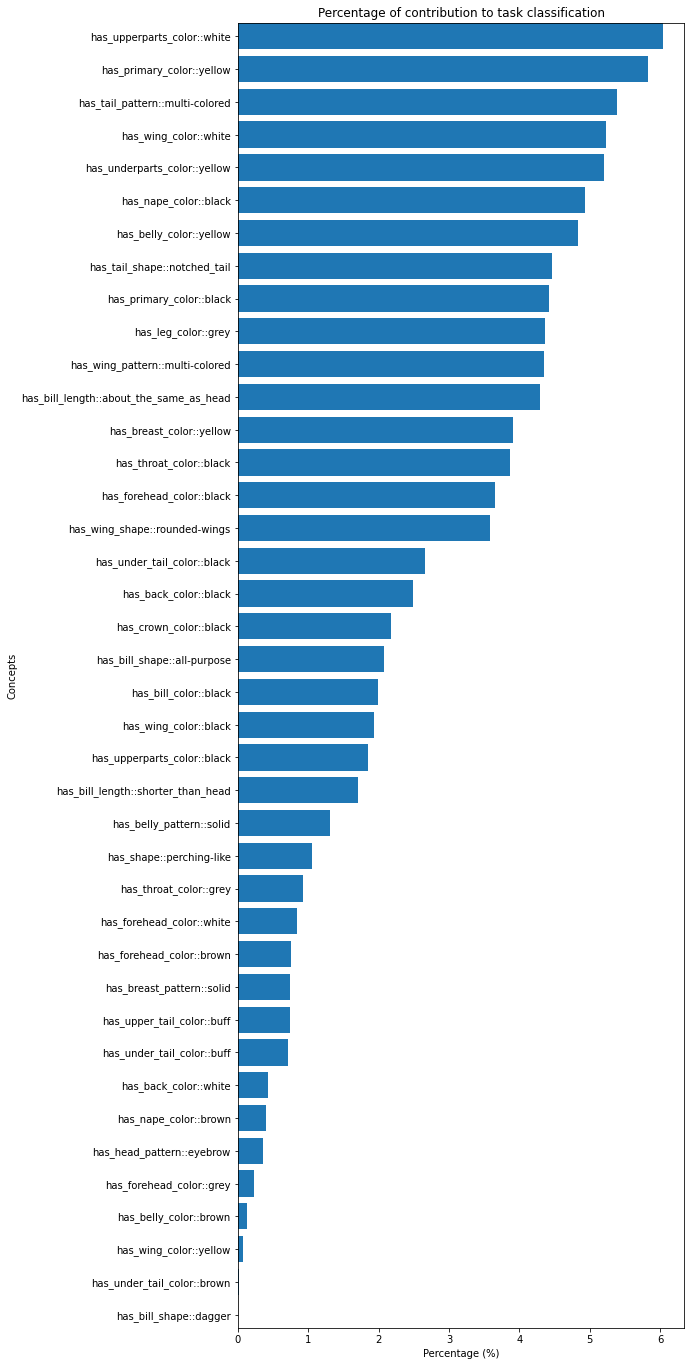

In [13]:
percentages = [round(float(x[1]*100), 3) for x in balaced_ratios]
labels = [concept_index_to_string(x[0]) for x in balaced_ratios]

print(percentages)
print(labels)

keep_percentages = []
zero_keep = 2
for i in percentages:
    if i > 0:
        keep_percentages.append(i)
    elif zero_keep > 1:
        keep_percentages.append(i)
        zero_keep -= 1
        
keep_labels = labels[:len(keep_percentages)]



y_pos = np.arange(len(keep_labels))

fig = plt.subplots(figsize = (8, 24)) 

plt.barh(y_pos, keep_percentages)
plt.ylabel("Concepts")
plt.xlabel("Percentage (%)")
plt.title("Percentage of contribution to task classification")

plt.yticks(y_pos, keep_labels)

plt.gca().invert_yaxis()
plt.margins(y=0)

plt.show()